In [1]:
import numpy as np
import pandas as pd
import cv2
import imutils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

In [2]:
def color_image_gray(folder,filename):
    """ Read an image from a folder, color it gray and inver it """
    image = cv2.imread(path.join(folder,filename))
    image2 = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return ~image2

def convert_image_into_binary_image(img):
    """ Conver a given image into binary so it be read by the computer """
    ret,bw_img = cv2.threshold(img,0,255, (cv2.THRESH_BINARY + cv2.THRESH_OTSU))
    return bw_img


In [3]:
img = cv2.imread("leapGestRecog/00/01_palm/frame_00_01_0019.png")
img = cv2.resize(img,(320,120))
img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
img = convert_image_into_binary_image(img)
img = img.reshape(320,120)

In [4]:
#plt.imshow(img)
img = img.astype("float32")
imgar = np.array([img,img,img])
x = torch.from_numpy(imgar).float()

In [5]:
x.size()

torch.Size([3, 320, 120])

In [6]:
z = np.stack((x,)*1,axis=-1).reshape(3,1,120,320)
y = torch.from_numpy(z).float()

In [7]:
class Model(nn.Module):
    def __init__(self,input_size=32, hidden_size=64,n_classes=10):
        """ Define our model """
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(1,input_size, kernel_size=(5,5),stride=(2,2))
        self.relu1 = nn.ReLU()
        self.maxp1 = nn.MaxPool2d(kernel_size=(2,2))
        self.conv2 = nn.Conv2d(input_size,hidden_size,kernel_size=(3,3))
        self.relu2 = nn.ReLU()
        self.maxp2 = nn.MaxPool2d(kernel_size=(2,2))
        self.l1    = nn.Linear(64*13*38,128)
        self.relul = nn.ReLU()
        self.l2    = nn.Linear(128,n_classes)
        self.soft  = nn.Softmax(1)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxp1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxp2(x)
        x = x.view(x.size(0),-1)
        x = self.l1(x)
        x = self.relul(x)
        x = self.l2(x)
        x = self.soft(x)
        return x

In [8]:
y.size()

torch.Size([3, 1, 120, 320])

In [9]:
model = Model()
d = model(y)

In [10]:
d

tensor([[2.8218e-04, 5.4885e-03, 5.0245e-05, 1.2629e-06, 1.5774e-04, 2.4647e-04,
         9.8744e-01, 5.2283e-03, 1.1007e-03, 3.6789e-07],
        [2.8218e-04, 5.4885e-03, 5.0245e-05, 1.2629e-06, 1.5774e-04, 2.4647e-04,
         9.8744e-01, 5.2283e-03, 1.1007e-03, 3.6789e-07],
        [2.8218e-04, 5.4885e-03, 5.0245e-05, 1.2629e-06, 1.5774e-04, 2.4647e-04,
         9.8744e-01, 5.2283e-03, 1.1007e-03, 3.6789e-07]],
       grad_fn=<SoftmaxBackward>)

In [13]:
train_loss = pd.read_csv("data/train_loss.csv")
train_accuracy =pd.read_csv("data/train_accuracy.csv")
valid_accuracy =pd.read_csv("data/valid_accuracy.csv")
valid_loss = pd.read_csv("data/valid_loss.csv")

test_output = pd.read_csv("data/test_output.csv")
test_label  = pd.read_csv("data/test_labels.csv")

epochs = np.arange(1,100)

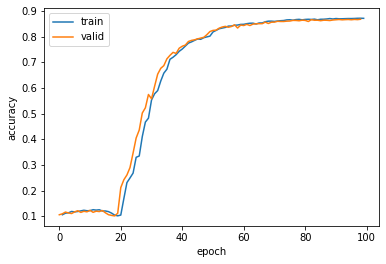

In [19]:
plt.plot(epochs,train_accuracy,valid_accuracy)
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend(["train","valid"])
plt.show()

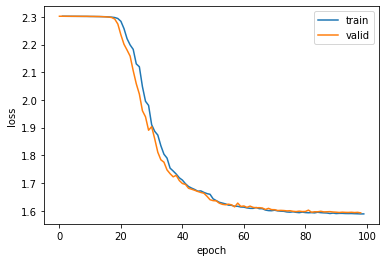

In [18]:
plt.plot(epochs,train_loss,valid_loss)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend(["train","valid"])
plt.show()

In [25]:
out = np.array(test_output)
lab = np.array(test_label)

In [29]:
out.sum()/19

1004.4736842105264

In [26]:
lab

array([[4., 5., 5., ..., 5., 5., 3.],
       [6., 4., 5., ..., 2., 6., 8.],
       [8., 7., 2., ..., 5., 0., 0.],
       ...,
       [4., 9., 5., ..., 5., 8., 1.],
       [2., 4., 6., ..., 0., 6., 9.],
       [9., 0., 1., ..., 1., 2., 4.]])

In [170]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

class dataLoader(Dataset):
    def __init__(self,transform=None):
        self.x = np.zeros((200,320,120))
        print(self.x.shape)
        self.y = np.zeros(200)
        self.x = np.stack((self.x,)*1,axis=-1)
        self.x = self.x.reshape(200,1,120,320)
        self.x = torch.from_numpy(self.x).float()
        self.y = torch.from_numpy(self.y).float()
        self.transform = transform
        
    def __getitem__(self,index):
        """ Data extraction from tensor """
        return self.x[index,:], self.y[index]
    def __len__(self):
        """ returns the length of the first dimension """
        return len(self.x) #20 000 images 4096 each

In [171]:
n = dataLoader(transform=transforms.ToTensor())

(200, 320, 120)


In [182]:
batch_size =1
shuffle = True
train, test = torch.utils.data.random_split(n, [120,80])
valid, test = torch.utils.data.random_split(test, [40,40])

train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=shuffle)
valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=shuffle)
test_loader  = DataLoader(dataset=test, batch_size=batch_size, shuffle=shuffle)
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


In [174]:
model = Model()
for x,y in train_loader:
    print(x.size())
    model.forward(x)
    print(x.size())
    break

torch.Size([1, 1, 320, 120])
torch.Size([1, 1, 320, 120])


In [199]:
def train(model,train_data,valid_data,learning_rate,num_epochs,optimizer,criterion):
    """ Training procedure of the model together with accuracy and loss for both data sets """
    train_loss = np.zeros(num_epochs)
    valid_loss = np.zeros(num_epochs)
    train_accuracy = np.zeros(num_epochs)
    valid_accuracy = np.zeros(num_epochs)

    """begin training"""
    for epoch in range(num_epochs):
        train_losses = []
        train_correct= 0
        total_items  = 0

        valid_losses = []
        valid_correct = 0

        for i,(images,labels) in enumerate(train_data):

            images = images.float()
            labels = labels.long()
            optimizer.zero_grad()

            """add to GPU hopefully"""
            images = images.to(device)
            labels = labels.to(device)

            """Forward pass"""
            outputs = model.forward(images)

            loss    = criterion(outputs,labels)

            """Backward pass"""
            loss.backward()
            optimizer.step()

            """staticstics"""
            train_losses.append(loss.item())
            _, predicted = torch.max(outputs.data,1)
            train_correct += (predicted == labels).sum().item()
            total_items += labels.size(0)

        train_loss[epoch] = np.mean(train_losses)
        train_accuracy[epoch] = (1 * train_correct/total_items)

        with torch.no_grad():
            correct_val = 0
            total_val = 0

            for i,(images,labels) in enumerate(valid_data):

                images = images.float()
                labels = labels.long()

                images = images.to(device)
                labels = labels.to(device)

                outputs = model.forward(images)
                loss    = criterion(outputs, labels)

                valid_losses.append(loss.item())
                _, predicted = torch.max(outputs.data, 1)

                correct_val += (predicted == labels).sum().item()
                total_val   += labels.size(0)

        valid_loss[epoch] = np.mean(valid_losses)
        valid_accuracy[epoch] = (1 * correct_val/total_val)

        print("Epoch: [{},{}], train accuracy: {}, valid accuracy: {}, train loss: {}, valid loss: {}"
        .format(num_epochs,epoch+1,train_accuracy[epoch],valid_accuracy[epoch],train_loss[epoch],valid_accuracy[epoch]))

    return model, train_accuracy, train_loss, valid_accuracy, valid_loss


In [180]:
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mode, ta, tl, va, vl = train(model,train_loader,valid_loader,0.001,2,optimizer,criterion)

Epoch: [2,1], train accuracy: 1.0, valid accuracy: 1.0, train loss: 1.4613142768541971, valid loss: 1.0
Epoch: [2,2], train accuracy: 1.0, valid accuracy: 1.0, train loss: 1.461283524831136, valid loss: 1.0


In [181]:
mode

Model(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2))
  (relu1): ReLU()
  (maxp1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxp2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (l1): Linear(in_features=31616, out_features=128, bias=True)
  (relul): ReLU()
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (soft): Softmax(dim=1)
)

In [202]:
from dataloader import dataloaderMain, create_dataset, read_dataset
from torch.utils.data import Dataset

csv_file = "data/database.csv"
root_dir = "data/"

class Data(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.anotation = dataloaderMain()
        print(type(self.anotation))
        print("loaded from csv")
        self.anotation = np.array(self.anotation)
        self.labels    = self.anotation[:,-1]
        self.anotation = np.delete(self.anotation,-1,axis=1)
        self.anotation = self.anotation.reshape(20000,320,120)
        self.anotation = np.stack((self.anotation,)*1,axis=-1)
        self.anotation = self.anotation.reshape(20000,1,320,120)
#        self.anotation = self.anotation.transpose()
        self.anotation = torch.from_numpy(self.anotation).float()
        self.labels = torch.from_numpy(self.labels).float()
        self.root_dir = root_dir
        self.transform = transform
        print("Clear")

    def __len__(self):
        """ returns the length of the first dimension """
        return len(self.anotation) #20 000 images 4096 each

    def __getitem__(self,index):
        """ Data extraction from tensor """
        return self.anotation[index,:], self.labels[index]


In [203]:
def Dataset(csv_file,root,batch_size,shuffle):

    """ Create three separate dataloaders which we can use to train, validate and test the network """

    dataset = Data(csv_file, root_dir=root,transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [14000,6000])
    valid, test = torch.utils.data.random_split(test, [3000,3000])

    train_loader = DataLoader(dataset=train, batch_size=batch_size, shuffle=shuffle)
    valid_loader = DataLoader(dataset=valid, batch_size=batch_size, shuffle=shuffle)

    test_loader  = DataLoader(dataset=test, batch_size=batch_size, shuffle=shuffle)

    return train_loader, valid_loader, test_loader

In [204]:
train,valid,test = Dataset(csv_file, root_dir, batch_size, shuffle)


Step: [100,1]
Step: [100,2]
Step: [100,3]
Step: [100,4]
Step: [100,5]
Step: [100,6]
Step: [100,7]
Step: [100,8]
Step: [100,9]
Step: [100,10]
Step: [100,11]
Step: [100,12]
Step: [100,13]
Step: [100,14]
Step: [100,15]
Step: [100,16]
Step: [100,17]
Step: [100,18]
Step: [100,19]
Step: [100,20]
Step: [100,21]
Step: [100,22]
Step: [100,23]
Step: [100,24]
Step: [100,25]
Step: [100,26]
Step: [100,27]
Step: [100,28]
Step: [100,29]
Step: [100,30]
Step: [100,31]
Step: [100,32]
Step: [100,33]
Step: [100,34]
Step: [100,35]
Step: [100,36]
Step: [100,37]
Step: [100,38]
Step: [100,39]
Step: [100,40]
Step: [100,41]
Step: [100,42]
Step: [100,43]
Step: [100,44]
Step: [100,45]
Step: [100,46]
Step: [100,47]
Step: [100,48]
Step: [100,49]
Step: [100,50]
Step: [100,51]
Step: [100,52]
Step: [100,53]
Step: [100,54]
Step: [100,55]
Step: [100,56]
Step: [100,57]
Step: [100,58]
Step: [100,59]
Step: [100,60]
Step: [100,61]
Step: [100,62]
Step: [100,63]
Step: [100,64]
Step: [100,65]
Step: [100,66]
Step: [100,67]
Step

MemoryError: Unable to allocate 732. MiB for an array with shape (20000, 320, 120, 1) and data type uint8

In [ ]:
model = Model()
optimizer = torch.optim.SGD(model.parameters(),lr=0.001,momentum=0.9)
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model, ta, tl, va, vl = train(model,train_loader,valid_loader,0.001,100,optimizer,criterion)